In [28]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.model_final import VisionTransformer, CONFIGS
from torchvision.datasets import CIFAR10

Files already downloaded and verified


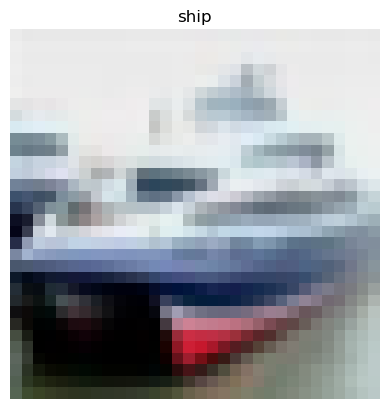

torch.Size([3, 32, 32])


In [ ]:
raw_dataset = CIFAR10(root='./data', train=False, download=True)
classes = raw_dataset.classes

transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

image_idx = 1

x = transform(raw_dataset[image_idx][0])

img = x.permute(1, 2, 0)  # 将 CHW 转换为 HWC

img = img * 0.5 + 0.5  # 逆归一化（从 [-1, 1] 到 [0, 1]）

plt.title(classes[raw_dataset[1][image_idx]])
plt.imshow(img)
plt.axis("off")
plt.show()

print(x.shape)

In [ ]:
config = CONFIGS["ViT-Ours_Final"]

model = VisionTransformer(config, num_classes=10, vis=True)
checkpoint_path = "/home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_3_checkpoint.bin" 
state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件
model.load_state_dict(state_dict)  # 加载模型参数
print(f"Loaded fine-tuned model from {checkpoint_path}")
model.eval()

Loaded fine-tuned model from /home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_3_checkpoint.bin


/tmp/ipykernel_1653085/3051229643.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件


VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (hybrid_model): ResNet_2(
        (block0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (block1): Sequential(
          (0): Residual(
            (conv1): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
            (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Residual(
            (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv2): C

In [39]:
from grad_rollout import VITAttentionGradRollout

grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.9)
mask = grad_rollout(x.unsqueeze(0), category_index=raw_dataset[1][image_idx])

In [32]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [33]:
name = classes[raw_dataset[1][image_idx]]

/tmp/ipykernel_1653085/1913104919.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np_img = np.array(img)[:, :, ::-1]  # Convert RGB to BGR for OpenCV


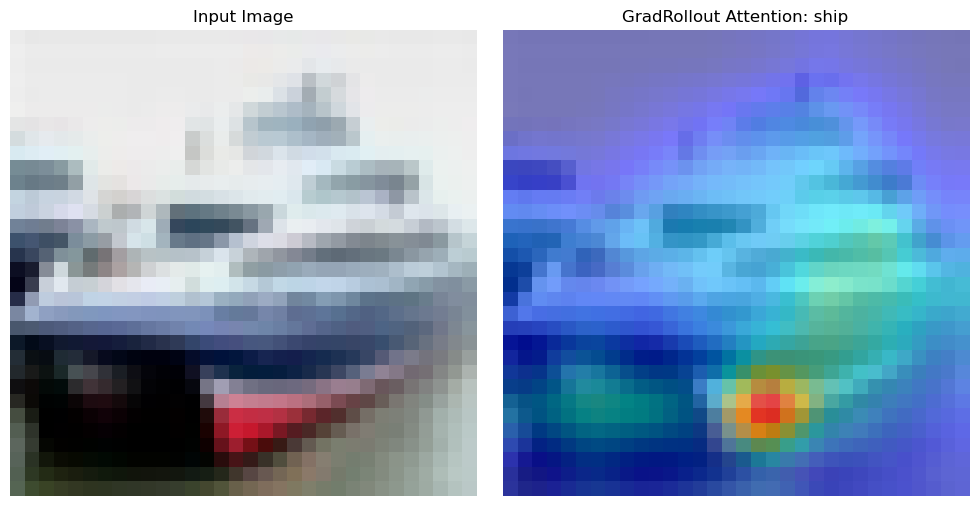

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Ensure output directory exists


# Get the image and class name
np_img = np.array(img)[:, :, ::-1]  # Convert RGB to BGR for OpenCV
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))  # Resize mask to match image dimensions

# Scale image to [0, 255] for show_mask_on_image
np_img = (np_img * 255).astype(np.float32)  # Scale from [0, 1] to [0, 255]
cam = show_mask_on_image(np_img, mask)  # Apply heatmap

# Convert BGR to RGB for Matplotlib
cam_rgb = cam[:, :, ::-1]
np_img_rgb = np_img[:, :, ::-1]

# Visualize using Matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(np_img_rgb.astype(np.uint8))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"GradRollout Attention: {name}")
plt.imshow(cam_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()

